# Figure 3: Do humans judge the unattested space as compositional?

In [5]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce

# import kendall_w.kendall_w as kw
import scipy.stats
from tqdm.auto import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import math
import statsmodels.api as sm

from composlang.utils import get_llm_results, minmax, compute_fit, JointDist

# import seaborn_image as isns

sns.set_theme()

In [3]:
def ECDF_transform(arr: np.ndarray):
    return ECDF(arr)(arr)

### Data-loading function

In [2]:
ratings = pd.read_csv("./simulate-comb-A-N/beh_stims_9907.csv")
ratings.sample(3)

,item,item_index,count,rt,age,trial_type,rating,adjective,noun
6670,plain purchaser,5128,10,15964.800000,31.900000,crit,0.200000,plain,purchaser
8617,substantial highway,9229,8,4650.500000,32.875000,crit,0.500000,substantial,highway
3697,fictional welfare,9916,11,6373.727273,35.090909,crit,0.727273,fictional,welfare


In [6]:
adj_p = pd.read_pickle("./simulate-comb-A-N/adj_p.pkl")
noun_p = pd.read_pickle("./simulate-comb-A-N/noun_p.pkl")
pair_p = pd.read_pickle("./simulate-comb-A-N/pair_p.pkl")
joint_p = pd.read_pickle("./simulate-comb-A-N/joint1000.pkl")
freqs = {"adj_p": adj_p, "noun_p": noun_p, "pair_p": pair_p, "joint_p": joint_p}

In [7]:
results = get_llm_results("gpt2_xl", "composlang-beh", **freqs)

** info: could not find logp_A in gpt2_xl x composlang-beh results; skipping
** info: could not find logp_A in gpt2_xl x composlang-beh results; skipping
** info: could not find logp_N in gpt2_xl x composlang-beh results; skipping


In [8]:
results

,adjective,age,clogp_A,clogp_AN,clogp_N,count,hybrid_logp_N_A,id,likert_constrained_optimized,likert_constrained_original,logp_AN,logp_N_A,model,noun,rating,rt,trial_type
0,African,32.375000,-6.709931,-inf,-9.969457,8,-21.334931,17362,1,1,-37.093750,-14.6250,gpt2_xl,catalog,4.000000,3491.375000,crit
1,African,29.636364,-6.709931,-inf,-7.418512,11,-16.834931,4587,1,1,-35.625000,-10.1250,gpt2_xl,chance,2.909091,4111.181818,crit
2,African,37.111111,-6.709931,-inf,-12.207759,9,-20.959931,9820,1,1,-37.218750,-14.2500,gpt2_xl,handset,3.333333,3138.666667,crit
3,African,42.666667,-6.709931,-inf,-11.080195,9,-21.397431,2021,1,1,-33.960938,-14.6875,gpt2_xl,inception,3.888889,4961.000000,crit
4,African,33.375000,-6.709931,-inf,-9.755796,8,-19.147431,11633,1,1,-34.750000,-12.4375,gpt2_xl,luxury,6.125000,3817.625000,crit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9902,young,41.333333,-5.404500,-inf,-10.822902,9,-18.029500,257,1,1,-31.843750,-12.6250,gpt2_xl,screw,2.666667,3588.333333,crit
9903,young,25.625000,-5.404500,-inf,-10.895498,8,-18.342000,14860,1,1,-31.937500,-12.9375,gpt2_xl,socket,2.125000,3872.375000,crit
9904,young,27.090909,-5.404500,-inf,-10.177143,11,-17.529500,5367,1,1,-34.562500,-12.1250,gpt2_xl,spacecraft,4.090909,4878.000000,crit
9905,young,32.500000,-5.404500,-inf,-10.058494,10,-16.279500,3659,1,1,-29.875000,-10.8750,gpt2_xl,taxi,2.300000,4184.800000,crit


In [5]:
ratings["adj_freq"] = ratings["adjective"].apply(str.lower).map(adj_freq)
ratings["noun_freq"] = ratings["noun"].apply(str.lower).map(noun_freq)
ratings["pair_freq"] = ratings["item"].apply(str.lower).map(pair_freq)
ratings.fillna(0, inplace=True)

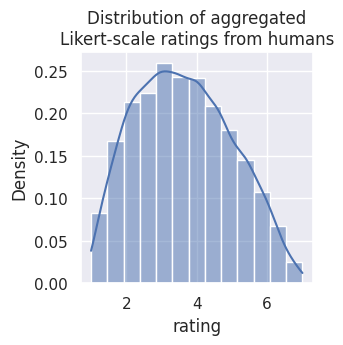

In [6]:
f, ax = plt.subplots(figsize=(3, 3))
sns.histplot(
    results.rating,
    kde=True,
    # element='poly',
    stat="density",
    bins=13,
)
ax.set_title("Distribution of aggregated\nLikert-scale ratings from humans")
plt.show()

In [9]:
denom = sum(adj_freq.values()) + sum(noun_freq.values())

In [11]:
results["adj_freq"] /= denom
results["noun_freq"] /= denom

In [17]:
# pick the first 5 and last 5 from:
print(
    results[["adjective", "noun", "adj_freq", "noun_freq", "rating"]]
    .sample(5)
    .sort_values("rating")
    .to_latex(index=False)
)

\begin{tabular}{llrrr}
\toprule
adjective &         noun &  adj\_freq &  noun\_freq &   rating \\
\midrule
   entire &     surveyor &  0.000384 &   0.000003 & 1.727273 \\
   native & subscription &  0.000199 &   0.000015 & 1.750000 \\
     twin &    recycling &  0.000034 &   0.000035 & 2.875000 \\
  Turkish &        smoke &  0.000041 &   0.000139 & 5.111111 \\
    sound &    checklist &  0.000008 &   0.000013 & 6.076923 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_946175/401822119.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results[["adjective", "noun", "adj_freq", "noun_freq", "rating"]]


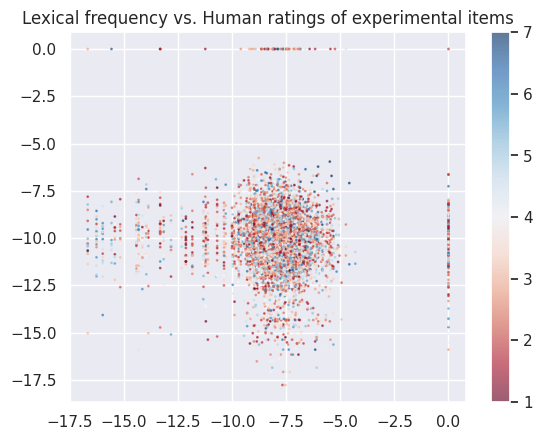

In [69]:
plt.scatter(
    results["clogp_A"],
    results["clogp_N"],
    c=results["rating"],
    s=1,
    alpha=0.6,
    cmap="RdBu",
)
plt.colorbar()
# plt.xlabel("Adj. Frequency")
# plt.ylabel("Noun Frequency")
# plt.xscale("log")
# plt.yscale("log")
plt.title("Lexical frequency vs. Human ratings of experimental items")

plt.show()

In [55]:
def compute_fit(data, target="rating", metric="logp_N_A"):
    y = data["metadata", target]
    x = data["model", metric]
    model = sm.OLS(y, sm.add_constant(x))
    fit = model.fit()

    return fit, dict(
        b=fit.params[0], m=fit.params[1], p=fit.pvalues[1], r2=fit.rsquared
    )


def plot_fit(data, metric="logp_N_A"):
    model_name = data["metadata", "model"].iloc[0]

    fit, info = compute_fit(data, metric=metric)
    b, m = fit.params
    print(fit.summary())
    f, ax = plt.subplots(figsize=(7, 5))

    y = data["metadata", "rating"]
    x = data["model", metric]
    ax.scatter(x, y, alpha=0.5, s=1)
    # ax.set_yscale("log")
    # ax.set_yscale("log")
    # extract intercept b and slope m
    # plot y = m*x + b
    ax.axline(
        xy1=(0, b),
        # xy2=(10, 10 * m + b),
        color="r",
        linewidth=2,
        linestyle="-",
        slope=m,
        label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
    )
    # ax.set_xlim(min(x), max(x))
    # ax.set_ylim(1, max(y))
    ax.legend(loc="lower right", bbox_to_anchor=(1, 0))
    ax.set_title(f"{model_name} {metric} predict human ratings")
    ax.set_xlabel(model_name + " " + metric)
    ax.set_ylabel("human ratings")

    plt.tight_layout()
    plt.show()